#**1. Data Cleaning**



In [ ]:
from google.colab import auth
auth.authenticate_user()
from google.colab import drive
drive.mount('/content/drive')
!pip install wbgapi
!pip install pandasql
!pip install yfinance
#import packages
from pandasql import sqldf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import yfinance as yf
import wbgapi as wb

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Special Notes:
<li>Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
<li>magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake. 

##**1.1. Import Data**

In [ ]:
transactions = pd.read_csv("/content/drive/My Drive/Springboard/Capstone3/transactions.csv", parse_dates = ['date'])
stores = pd.read_csv("/content/drive/My Drive/Springboard/Capstone3/stores.csv")
oil = pd.read_csv("/content/drive/My Drive/Springboard/Capstone3/oil.csv", parse_dates = ['date'])
holidays_events = pd.read_csv("/content/drive/My Drive/Springboard/Capstone3/holidays_events.csv", parse_dates = ['date'])
train = pd.read_csv("/content/drive/My Drive/Springboard/Capstone3/train.csv", parse_dates = ['date'])
test = pd.read_csv("/content/drive/My Drive/Springboard/Capstone3/test_V2.csv", parse_dates = ['date'])
sample_submission = pd.read_csv("/content/drive/My Drive/Springboard/Capstone3/sample_submission.csv")

In [ ]:
train.groupby('family').sum('sales').sort_values('sales', ascending = False).index

Index(['GROCERY I', 'BEVERAGES', 'PRODUCE', 'CLEANING', 'DAIRY',
       'BREAD/BAKERY', 'POULTRY', 'MEATS', 'PERSONAL CARE', 'DELI',
       'HOME CARE', 'EGGS', 'FROZEN FOODS', 'PREPARED FOODS',
       'LIQUOR,WINE,BEER', 'SEAFOOD', 'GROCERY II', 'HOME AND KITCHEN I',
       'HOME AND KITCHEN II', 'CELEBRATION', 'LINGERIE', 'LADIESWEAR',
       'PLAYERS AND ELECTRONICS', 'AUTOMOTIVE', 'LAWN AND GARDEN',
       'PET SUPPLIES', 'BEAUTY', 'SCHOOL AND OFFICE SUPPLIES', 'MAGAZINES',
       'HARDWARE', 'HOME APPLIANCES', 'BABY CARE', 'BOOKS'],
      dtype='object', name='family')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [ ]:
train.date.max()

Timestamp('2017-08-15 00:00:00')

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.1+ MB


In [ ]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [ ]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [ ]:
holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [ ]:
holidays_events['weekday'] = holidays_events['date'].dt.day_name()

In [ ]:
holidays_events.type.value_counts()

Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: type, dtype: int64

In [ ]:
holidays_events[holidays_events.type == 'Work Day']

,date,type,locale,locale_name,description,transferred,weekday
42,2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,False,Saturday
43,2013-01-12,Work Day,National,Ecuador,Recupero puente primer dia del ano,False,Saturday
149,2014-12-20,Work Day,National,Ecuador,Recupero Puente Navidad,False,Saturday
161,2015-01-10,Work Day,National,Ecuador,Recupero Puente Primer dia del ano,False,Saturday
283,2016-11-12,Work Day,National,Ecuador,Recupero Puente Dia de Difuntos,False,Saturday


## **1.2. Create Macro-Economic Features**

1) Since Ecuador's economy is heavily dependent on oil import, we will get the crude oil prices from yahoo finance together with the stock price of a pulic listing oil company (exxon mobil)

2) Get other macro-economic data from world bank: population, inflation (CPI)

###**1.2.1. Handle missing oil price data**

In [ ]:
oil.date.min(), oil.date.max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-31 00:00:00'))

In [ ]:
#create continuous date range from min to max 
daterange = pd.DataFrame(pd.date_range(start=oil.date.min(),end=oil.date.max()), columns = ['date'])

In [ ]:
#Get crude oil data from yfinance
ticker = 'CL=F'
crude = yf.Ticker(ticker)
df_crude = crude.history(start = '2013-01-01', end = '2017-08-31')['Close'].reset_index()
df_crude['Date'] = pd.to_datetime(df_crude['Date'])
df_crude.head(10)

,Date,Close
0,2013-01-02 00:00:00-05:00,93.120003
1,2013-01-03 00:00:00-05:00,92.919998
2,2013-01-04 00:00:00-05:00,93.089996
3,2013-01-07 00:00:00-05:00,93.190002
4,2013-01-08 00:00:00-05:00,93.150002
5,2013-01-09 00:00:00-05:00,93.099998
6,2013-01-10 00:00:00-05:00,93.820000
7,2013-01-11 00:00:00-05:00,93.559998
8,2013-01-14 00:00:00-05:00,94.139999
9,2013-01-15 00:00:00-05:00,93.279999


In [ ]:
pysqldf = lambda q: sqldf(q, globals())

In [ ]:
q = """SELECT daterange.date
       ,CASE WHEN (oil.dcoilwtico > 0) THEN oil.dcoilwtico 
        WHEN (df_crude.Close > 0) THEN df_crude.Close 
        ELSE NULL END AS oil_price 
       FROM daterange
       LEFT JOIN oil on oil.date = daterange.date
       LEFT JOIN df_crude ON daterange.date = df_crude.Date  
       ;"""
oil_price = pysqldf(q)
oil_price['date'] = pd.to_datetime(oil_price['date'])


In [ ]:
oil_price.isnull().mean()

date         0.000000
oil_price    0.309859
dtype: float64

In [ ]:
#Missing oil price and stock price values happened when the stock exchange closes (weekend + new year). Impute missing values using ffill method (stock prices remain the same when the market closes)
oil_price['oil_price'][0] = oil_price['oil_price'][1]
#LOCF
oil_price['oil_price_ffill'] = oil_price['oil_price'].fillna(method = 'ffill')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
oil_price.head(10)

,date,oil_price,oil_price_ffill
0,2013-01-01,93.14,93.14
1,2013-01-02,93.14,93.14
2,2013-01-03,92.97,92.97
3,2013-01-04,93.12,93.12
4,2013-01-05,NaN,93.12
5,2013-01-06,NaN,93.12
6,2013-01-07,93.20,93.20
7,2013-01-08,93.21,93.21
8,2013-01-09,93.08,93.08
9,2013-01-10,93.81,93.81


###**1.2.2. Exxon stock prices (proxy for oil prices)**

In [ ]:
ticker = 'XOM'
exxon = yf.Ticker(ticker)
df_exxon = exxon.history(start = '2013-01-01', end = '2017-08-31').Close.reset_index()

In [ ]:
q = """SELECT daterange.date
       ,CASE WHEN (df_exxon.Close > 0) THEN df_exxon.Close 
        ELSE NULL END AS Close 
       FROM daterange
       LEFT JOIN df_exxon on df_exxon.Date = daterange.date
       ;"""
exxon = pysqldf(q)
exxon['date'] = pd.to_datetime(exxon['date'])
exxon.head(10)

,date,Close
0,2013-01-01,NaN
1,2013-01-02,58.550945
2,2013-01-03,58.445335
3,2013-01-04,58.715946
4,2013-01-05,NaN
5,2013-01-06,NaN
6,2013-01-07,58.036121
7,2013-01-08,58.399128
8,2013-01-09,58.174736
9,2013-01-10,58.808369


In [ ]:
#Fill missing value using forward fill (all the days when stock exchange closed)
exxon.Close[0] = exxon.Close[1]
exxon['Close'] = exxon['Close'].fillna(method = 'ffill')
exxon.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,date,Close
0,2013-01-01,58.550945
1,2013-01-02,58.550945
2,2013-01-03,58.445335
3,2013-01-04,58.715946
4,2013-01-05,58.715946
5,2013-01-06,58.715946
6,2013-01-07,58.036121
7,2013-01-08,58.399128
8,2013-01-09,58.174736
9,2013-01-10,58.808369


###**1.2.3. Other macro-economics features**

In [ ]:
country = 'ECU'
indicators = ['SP.POP.TOTL','NY.GDP.PCAP.CD','FP.CPI.TOTL.ZG']

macro_df = wb.data.DataFrame(indicators, country, range(2013, 2018)).T.reset_index()
macro_df.columns = ['year','CPI','GDPPCAP','POP']
macro_df.year = macro_df.year.str.strip('YR')
macro_df.head()

,year,CPI,GDPPCAP,POP
0,2013,2.721776,6056.331213,15707473.0
1,2014,3.589220,6377.093929,15951832.0
2,2015,3.966646,6124.490887,16212022.0
3,2016,1.728265,6060.092962,16491116.0
4,2017,0.417336,6213.503127,16785356.0


In [ ]:
macro_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   year     5 non-null      object 
 1   CPI      5 non-null      float64
 2   GDPPCAP  5 non-null      float64
 3   POP      5 non-null      float64
dtypes: float64(3), object(1)
memory usage: 288.0+ bytes


###**1.2.4. Combine all indicators with sales data**

In [ ]:
transactions_agg = transactions.groupby('date').agg({'transactions':'sum'}).reset_index()
sales_agg = train.groupby('date').agg({'sales':'sum'}).reset_index()

In [ ]:
daterange.date.dt.year

0       2013
1       2013
2       2013
3       2013
4       2013
        ... 
1699    2017
1700    2017
1701    2017
1702    2017
1703    2017
Name: date, Length: 1704, dtype: int64

In [ ]:
q = """SELECT date
       ,day_off
       ,max(locale) as locale
       FROM
      (SELECT date
       ,case when (holidays_events.type == 'Holiday' and holidays_events.transferred == 0) then 1 
             when (holidays_events.type == 'Transfer' and holidays_events.transferred == 1) then 1
             when (holidays_events.type == 'Bridge') then 1
        else 0 end as day_off
        ,case when locale == 'National' then 3
              when locale == 'Regional' then 2
              when locale == 'Local' then 1
              else 0 end as locale 
       FROM holidays_events
       WHERE day_off = 1)
       GROUP BY date
       ;"""
holiday_agg = pysqldf(q)
holiday_agg['date'] = pd.to_datetime(holiday_agg['date'])
holiday_agg = holiday_agg.drop_duplicates()
holiday_agg.head()

,date,day_off,locale
0,2012-03-02,1,1
1,2012-04-01,1,2
2,2012-04-12,1,1
3,2012-04-14,1,1
4,2012-04-21,1,1


In [ ]:
q = """SELECT daterange.date
       ,exxon.Close as exxon_price
       ,oil_price.oil_price_ffill as oil
       ,macro_df.CPI
       ,macro_df.GDPPCAP
       ,macro_df.POP
       ,transactions_agg.transactions
       ,sales_agg.sales
       ,IFNULL(holiday_agg.day_off, 0) as day_off
       ,IFNULL(holiday_agg.locale, 0) as locale
       FROM daterange
       LEFT JOIN transactions_agg on transactions_agg.date = daterange.date
       LEFT JOIN holiday_agg on holiday_agg.date = daterange.date
       LEFT JOIN sales_agg on sales_agg.date = daterange.date
       LEFT JOIN exxon on exxon.date = daterange.date
       LEFT JOIN oil_price on oil_price.date = daterange.date
       LEFT JOIN macro_df on macro_df.year = strftime('%Y',daterange.date)
       ;"""
daily_sales_agg = pysqldf(q)
daily_sales_agg['date'] = pd.to_datetime(daily_sales_agg['date'])
daily_sales_agg.head(10)

,date,exxon_price,oil,CPI,GDPPCAP,POP,transactions,sales,day_off,locale
0,2013-01-01,58.550945,93.14,2.721776,6056.331213,15707473.0,770.0,2511.618999,1,3
1,2013-01-02,58.550945,93.14,2.721776,6056.331213,15707473.0,93215.0,496092.417944,0,0
2,2013-01-03,58.445335,92.97,2.721776,6056.331213,15707473.0,78504.0,361461.231124,0,0
3,2013-01-04,58.715946,93.12,2.721776,6056.331213,15707473.0,78494.0,354459.677093,0,0
4,2013-01-05,58.715946,93.12,2.721776,6056.331213,15707473.0,93573.0,477350.121229,0,0
5,2013-01-06,58.715946,93.12,2.721776,6056.331213,15707473.0,90464.0,519695.401088,0,0
6,2013-01-07,58.036121,93.20,2.721776,6056.331213,15707473.0,75597.0,336122.801066,0,0
7,2013-01-08,58.399128,93.21,2.721776,6056.331213,15707473.0,72325.0,318347.777981,0,0
8,2013-01-09,58.174736,93.08,2.721776,6056.331213,15707473.0,71971.0,302530.809018,0,0
9,2013-01-10,58.808369,93.81,2.721776,6056.331213,15707473.0,66383.0,258982.003049,0,0


In [ ]:
daily_sales_agg[daily_sales_agg['transactions'].isnull()]

,date,exxon_price,oil,CPI,GDPPCAP,POP,transactions,sales,day_off,locale
358,2013-12-25,67.275459,98.87,2.721776,6056.331213,15707473.0,NaN,NaN,1,3
723,2014-12-25,65.389885,55.70,3.589220,6377.093929,15951832.0,NaN,NaN,1,3
1088,2015-12-25,57.211838,37.62,3.966646,6124.490887,16212022.0,NaN,NaN,1,3
1095,2016-01-01,56.216599,37.13,1.728265,6060.092962,16491116.0,NaN,1.643339e+04,1,3
1097,2016-01-03,56.216599,37.13,1.728265,6060.092962,16491116.0,NaN,1.226736e+06,0,0
1454,2016-12-25,67.729645,52.01,1.728265,6060.092962,16491116.0,NaN,NaN,1,3
1688,2017-08-16,59.495155,46.80,0.417336,6213.503127,16785356.0,NaN,NaN,0,0
1689,2017-08-17,58.565891,47.07,0.417336,6213.503127,16785356.0,NaN,NaN,0,0
1690,2017-08-18,58.857742,48.59,0.417336,6213.503127,16785356.0,NaN,NaN,0,0
1691,2017-08-19,58.857742,48.59,0.417336,6213.503127,16785356.0,NaN,NaN,0,0


In [ ]:
#Handle missing sales values with forward fill
daily_sales_agg[daily_sales_agg.date < '2017-08-16']['transactions'] = daily_sales_agg[daily_sales_agg.date < '2017-08-16']['transactions'].fillna(method = 'ffill')
daily_sales_agg[daily_sales_agg.date < '2017-08-16']['sales'] = daily_sales_agg[daily_sales_agg.date < '2017-08-16']['sales'].fillna(method = 'ffill')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#Add salary day
from pandas.tseries.offsets import DateOffset
daily_sales_agg['end_of_month'] = daily_sales_agg['date'].dt.is_month_end
daily_sales_agg['mid_month'] = (daily_sales_agg['date'] + DateOffset(days =-14)).dt.is_month_start
daily_sales_agg['salary_day'] = daily_sales_agg['end_of_month'] + daily_sales_agg['mid_month']
daily_sales_agg = daily_sales_agg.drop(['mid_month','end_of_month'], axis = 1)

In [ ]:
daily_sales_agg[daily_sales_agg['salary_day'] == True].head(15)

,date,exxon_price,oil,CPI,GDPPCAP,POP,transactions,sales,day_off,locale,salary_day
14,2013-01-15,59.092186,93.26,2.721776,6056.331213,15707473.0,71134.0,299129.549954,0,0,True
30,2013-01-31,59.382587,97.65,2.721776,6056.331213,15707473.0,70268.0,271254.217996,0,0,True
45,2013-02-15,58.692543,95.95,2.721776,6056.331213,15707473.0,75789.0,320168.883912,0,0,True
58,2013-02-28,59.482979,92.03,2.721776,6056.331213,15707473.0,69818.0,278116.291888,0,0,True
73,2013-03-15,59.363422,93.49,2.721776,6056.331213,15707473.0,75533.0,315878.090213,0,0,True
89,2013-03-31,59.854965,97.24,2.721776,6056.331213,15707473.0,82563.0,462107.639956,0,0,True
104,2013-04-15,57.450401,88.75,2.721776,6056.331213,15707473.0,76251.0,338712.458055,0,0,True
119,2013-04-30,59.110989,93.22,2.721776,6056.331213,15707473.0,73513.0,310186.466894,0,0,True
134,2013-05-15,61.024811,93.95,2.721776,6056.331213,15707473.0,74401.0,329113.560081,0,0,True
150,2013-05-31,60.509811,91.93,2.721776,6056.331213,15707473.0,76921.0,330257.841975,0,0,True


In [ ]:
daily_sales_agg['year'] = pd.DatetimeIndex(daily_sales_agg.date).year
daily_sales_agg['month'] = pd.DatetimeIndex(daily_sales_agg.date).month
daily_sales_agg['quarter'] = pd.DatetimeIndex(daily_sales_agg.date).quarter

In [ ]:
daily_sales_agg.to_csv('/content/drive/MyDrive/Springboard/Capstone3/daily_sales_agg.csv', index = False)

##**1.3. Prepare data at stores level**

In [ ]:
holidays_events

,date,type,locale,locale_name,description,transferred,weekday
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,Friday
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,Sunday
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,Thursday
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,Saturday
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,Saturday
...,...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False,Friday
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False,Saturday
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False,Sunday
348,2017-12-25,Holiday,National,Ecuador,Navidad,False,Monday


In [ ]:
q = """SELECT date
       ,locale_name
       FROM holidays_events
       WHERE locale in ('National')
       AND ((type == 'Holiday' and transferred == 0)
             OR (type == 'Transfer' and transferred == 1)
             OR (type == 'Bridge'))
       ;"""
holiday_national = pysqldf(q)
holiday_national['date'] = pd.to_datetime(holiday_national['date'])
holiday_national = holiday_national.drop_duplicates()
holiday_national.head()

,date,locale_name
0,2012-08-10,Ecuador
1,2012-11-02,Ecuador
2,2012-11-03,Ecuador
3,2012-12-24,Ecuador
4,2012-12-25,Ecuador


In [ ]:
q = """SELECT date
       ,locale_name
       FROM holidays_events
       WHERE locale in ('Regional')
       AND ((type == 'Holiday' and transferred == 0)
             OR (type == 'Transfer' and transferred == 1)
             OR (type == 'Bridge'))
       ;"""
holiday_regional = pysqldf(q)
holiday_regional['date'] = pd.to_datetime(holiday_regional['date'])
holiday_regional = holiday_regional.drop_duplicates()
holiday_regional.head()

,date,locale_name
0,2012-04-01,Cotopaxi
1,2012-06-25,Imbabura
2,2012-11-06,Santo Domingo de los Tsachilas
3,2012-11-07,Santa Elena
4,2013-04-01,Cotopaxi


In [ ]:
q = """SELECT date
       ,locale_name
       FROM holidays_events
       WHERE locale in ('Local')
       AND ((type == 'Holiday' and transferred == 0)
             OR (type == 'Transfer' and transferred == 1)
             OR (type == 'Bridge'))
       ;"""
holiday_local = pysqldf(q)
holiday_local['date'] = pd.to_datetime(holiday_local['date'])
holiday_local = holiday_local.drop_duplicates()
holiday_local.head()

,date,locale_name
0,2012-03-02,Manta
1,2012-04-12,Cuenca
2,2012-04-14,Libertad
3,2012-04-21,Riobamba
4,2012-05-12,Puyo


In [ ]:
q = """SELECT *

       FROM daterange 
       CROSS JOIN (SELECT store_nbr FROM stores)

       ;"""

date_store = pysqldf(q)
date_store['date'] = pd.to_datetime(date_store['date'])
date_store = date_store.drop_duplicates()
date_store.head()

,date,store_nbr
0,2013-01-01,1
1,2013-01-01,2
2,2013-01-01,3
3,2013-01-01,4
4,2013-01-01,5


In [ ]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [ ]:
q = """SELECT ds.date
       , ds.store_nbr
       , macro_df.POP
       , macro_df.CPI
       , oil_price.oil_price_ffill as oil
       , CASE WHEN n.date is not null THEN 1
              WHEN r.date is not null THEN 1
              WHEN l.date is not null THEN 1
              ELSE 0 END AS holiday
       , sum(train.sales) as sales
       , sum(train.onpromotion) as items_on_promo 
       FROM date_store as ds
       LEFT JOIN train ON ds.date = train.date AND ds.store_nbr = train.store_nbr
       LEFT JOIN transactions ON transactions.store_nbr = ds.store_nbr AND ds.date = transactions.date
       LEFT JOIN holiday_national AS n ON n.date = ds.date
       LEFT JOIN stores on stores.store_nbr = ds.store_nbr
       LEFT JOIN holiday_regional AS r ON r.date = ds.date AND r.locale_name = stores.state
       LEFT JOIN holiday_local AS l ON l.date = ds.date AND l.locale_name = stores.city
       LEFT JOIN macro_df ON macro_df.year = strftime('%Y',ds.date)
       LEFT JOIN oil_price ON oil_price.date = ds.date
       GROUP BY ds.date, ds.store_nbr, POP, CPI, oil, holiday
       ;"""

df = pysqldf(q)
df['date'] = pd.to_datetime(df['date'])
df = df.drop_duplicates()
df.head()

,date,store_nbr,POP,CPI,oil,holiday,sales,items_on_promo
0,2013-01-01,1,15707473.0,2.721776,93.14,1,0.0,0.0
1,2013-01-01,2,15707473.0,2.721776,93.14,1,0.0,0.0
2,2013-01-01,3,15707473.0,2.721776,93.14,1,0.0,0.0
3,2013-01-01,4,15707473.0,2.721776,93.14,1,0.0,0.0
4,2013-01-01,5,15707473.0,2.721776,93.14,1,0.0,0.0


In [ ]:
df.to_csv('/content/drive/MyDrive/Springboard/Capstone3/daily_sales_stores.csv', index = False)

In [ ]:
df[df['store_nbr'] == 44].head(300)

,date,store_nbr,POP,CPI,oil,holiday,sales,items_on_promo
43,2013-01-01,44,15707473.0,2.721776,93.14,1,0.0000,0.0
97,2013-01-02,44,15707473.0,2.721776,93.14,0,30095.1810,0.0
151,2013-01-03,44,15707473.0,2.721776,92.97,0,20447.0570,0.0
205,2013-01-04,44,15707473.0,2.721776,93.12,0,22795.7990,0.0
259,2013-01-05,44,15707473.0,2.721776,93.12,0,31382.5080,0.0
...,...,...,...,...,...,...,...,...
15973,2013-10-23,44,15707473.0,2.721776,96.90,0,19598.1060,0.0
16027,2013-10-24,44,15707473.0,2.721776,96.65,0,14100.9440,0.0
16081,2013-10-25,44,15707473.0,2.721776,97.40,0,18478.7850,0.0
16135,2013-10-26,44,15707473.0,2.721776,97.40,0,28339.6199,0.0


##**1.4. Data at product family level**

In [ ]:
q = """SELECT *

       FROM daterange 
       CROSS JOIN (SELECT DISTINCT family FROM train)

       ;"""

date_fam = pysqldf(q)
date_fam['date'] = pd.to_datetime(date_fam['date'])
date_fam = date_fam.drop_duplicates()
date_fam.head()

,date,family
0,2013-01-01,AUTOMOTIVE
1,2013-01-01,BABY CARE
2,2013-01-01,BEAUTY
3,2013-01-01,BEVERAGES
4,2013-01-01,BOOKS


In [ ]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [ ]:
q = """SELECT ds.date
       , ds.family
       , macro_df.POP
       , macro_df.CPI
       , oil_price.oil_price_ffill as oil
       , sum(train.sales) as sales
       , sum(train.onpromotion) as items_on_promo 
       FROM date_fam as ds
       LEFT JOIN train ON ds.date = train.date AND ds.family = train.family
       LEFT JOIN macro_df ON macro_df.year = strftime('%Y',ds.date)
       LEFT JOIN oil_price ON oil_price.date = ds.date
       GROUP BY ds.date, ds.family, POP, CPI, oil
       ;"""

df2 = pysqldf(q)
df2['date'] = pd.to_datetime(df2['date'])
df2 = df2.drop_duplicates()
df2.head()

,date,family,POP,CPI,oil,sales,items_on_promo
0,2013-01-01,AUTOMOTIVE,15707473.0,2.721776,93.14,0.0,0.0
1,2013-01-01,BABY CARE,15707473.0,2.721776,93.14,0.0,0.0
2,2013-01-01,BEAUTY,15707473.0,2.721776,93.14,2.0,0.0
3,2013-01-01,BEVERAGES,15707473.0,2.721776,93.14,810.0,0.0
4,2013-01-01,BOOKS,15707473.0,2.721776,93.14,0.0,0.0


In [ ]:
df2.to_csv('/content/drive/MyDrive/Springboard/Capstone3/daily_sales_family.csv', index = False)

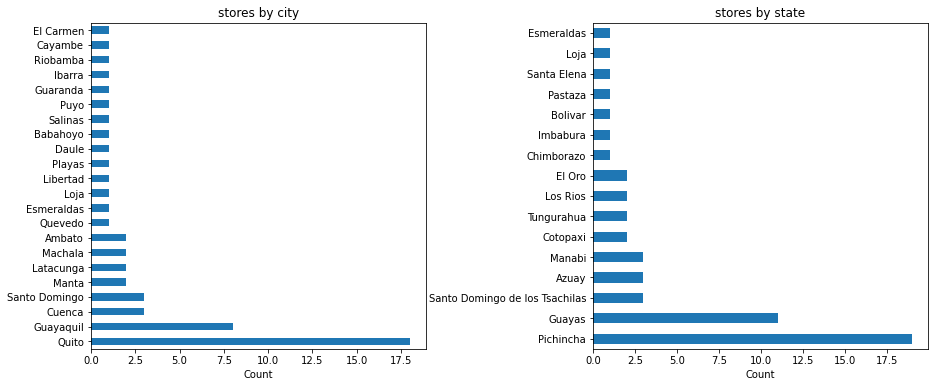

In [ ]:
#Distribution of stores by city and state
fig, ax = plt.subplots(1, 2, figsize=(15,6))
stores.city.value_counts().plot(kind='barh', ax=ax[0])
ax[0].set_title('stores by city')
ax[0].set_xlabel('Count')
stores.state.value_counts().plot(kind='barh', ax=ax[1])
ax[1].set_title('stores by state')
ax[1].set_xlabel('Count')
plt.subplots_adjust(wspace=0.5);

In [ ]:
#Sales distribution by stores 
sales_agg_store = df.groupby('store_nbr').agg({'sales':'sum'}).sort_values(by = 'sales', ascending = False).reset_index()
sales_agg_store['perc'] = 100*sales_agg_store['sales']/sales_agg_store['sales'].sum()
sales_agg_store['sales _perc_cum'] = sales_agg_store['perc'].cumsum()
sales_agg_store['store_count_perc'] = 100*(sales_agg_store.index+1)/sales_agg_store['store_nbr'].count()

In [ ]:
sales_agg_store

,store_nbr,sales,perc,sales _perc_cum,store_count_perc
0,44,6.208755e+07,5.782876,5.782876,1.851852
1,45,5.449801e+07,5.075981,10.858856,3.703704
2,47,5.094831e+07,4.745359,15.604216,5.555556
3,3,5.048191e+07,4.701918,20.306134,7.407407
4,49,4.342010e+07,4.044176,24.350311,9.259259
5,46,4.189606e+07,3.902227,28.252537,11.111111
6,48,3.593313e+07,3.346835,31.599373,12.962963
7,51,3.291149e+07,3.065398,34.664771,14.814815
8,8,3.049429e+07,2.840258,37.505029,16.666667
9,50,2.865302e+07,2.668761,40.173790,18.518519


OBSERVATION: 26% stores (14) contribute more than 50% total sales. We can focus our forecasting excercise on these stores